# Bulk Download Data with `earthaccess`

Whew – we’ve processed some reflectance data! But you may have noticed
that your image doesn’t include all of Denver, or all the spectral bands
you will need – Your search returned 60 different files covering
different spectral bands and spatial areas! To work with all of them, we
will have to utilize **DRY** coding techniques – `for` loops and
functions.

First things first – load your stored variables into memory:

In [1]:
%store -r denver_redlining_gdf data_dir

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Import packages</div></div><div class="callout-body-container callout-body"><p>Add imports for packages that help you:</p>
<ol type="1">
<li>Work with the file system interoperably</li>
<li>Work with vector data</li>
<li>Create interactive plots of vector data</li>
<li>Group and aggregate tabular data</li>
</ol></div></div>

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Set up `earthaccess` connection</div></div><div class="callout-body-container callout-body"><p>As you did before, log in to your <code>earthaccess</code> account,
search for the Denver data, and open the file connections. You will find
that you have to re-run your search every time you access a file – keep
this in mind if you get errors later!</p></div></div>

In [2]:
import re # Use regular expressions to extract metadata

import earthaccess # Access NASA data from the cloud
import matplotlib.pyplot # Overlay raster and vector data
import numpy as np # Process bit-wise cloud mask
import pandas as pd # Group and aggregate
import rioxarray as rxr # Work with raster data
from rioxarray.merge import merge_arrays # Merge rasters
import os # Reproducible file paths

In [3]:
earthaccess.login(strategy="interactive", persist=True)

In [4]:
denver_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(denver_redlining_gdf.total_bounds),
    # temporal=("2023-07-17"), # works but no granules 
    # temporal=("2023-07-17","2023-07-18"), # gives error
    # temporal=("2023-07-17"),
    temporal=("2023-07-12","2023-07-13"), #class example
    # temporal=("2023-07-01","2023-07-31"),
    # temporal=("2024-10-16","2024-10-17"), #try another day
    count=1
    
)
    # Check if any results were found
denver_results

[Collection: {'EntryTitle': 'HLS Landsat Operational Land Imager Surface Reflectance and TOA Brightness Daily Global 30m v2.0'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -105.84822916, 'Latitude': 38.7577866}, {'Longitude': -104.88766444, 'Latitude': 38.76081048}, {'Longitude': -104.88607437, 'Latitude': 39.75021202}, {'Longitude': -105.55700976, 'Latitude': 39.74893151}, {'Longitude': -105.84822916, 'Latitude': 38.7577866}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2023-07-12T17:36:53.600Z', 'EndingDateTime': '2023-07-12T17:37:17.491Z'}}
 Size(MB): 132.62681674957275
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.SZA.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.B04.tif', 'https://dat

In [5]:
denver_file_data = earthaccess.open(denver_results)

QUEUEING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/15 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/15 [00:00<?, ?it/s]

In [6]:
denver_file_data

[<File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.SZA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.B04.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.B07.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.B01.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.VAA.tif>,
 <File-like object HTTPFileSystem, https://data.lpdaac.earth

## Putting it all together

To get a complete image, we will have to:

1.  Load in all 4 rasters that cover Denver
2.  Process them
3.  Merge, or mosaic, them into one image

And…we haven’t even talked about the other bands you might need, or what
to do if you want a time-series of images. You can see that if we were
to copy and paste all the code above for each raster we need to load, it
could get pretty overwhelming, and *very* error-prone. This is the
opposite of what we mean by **DRY** (Don’t Repeat Yourself) code.

Before we continue, we’re going to make some functions to do the tasks
you completed up above. We’ve already set up the code for you,
identified **parameters** and **returns**, and added **docstrings** to
document your function. When writing a function, we recommend the
following process:

1.  Copy the code you’re using into the function shell, making sure to
    indent it so Python knows it is part of the function.
2.  Identify any variables that are **too specific**. For example, if I
    called a `DataArray` `denver_da`, but I could use my function to
    process data from anywhere…I might change the name to `da` whereever
    it appears.
3.  Identify the function **parameters** or arguments and make sure they
    match your code. Python may let you, but we recommend not using
    variables defined outside the function inside the function – if you
    need something in your function make sure to pass it in as a
    parameter!
4.  Identify the function **returns** and make sure they match your
    code. What do you want to be able to access at the end? Keep in mind
    that unless you return them, the variables you create in a function
    will be stuck there. The `return` statement at the end of your
    function will pass the variables you want to keep back out of the
    function.
5.  Write some code to test your function, such as by plotting the
    results. We recommend going line by line when you’re just getting
    started. This usually involves commenting code later on, and
    modifying the returns and test code as you go.
6.  Restart the kernel and run your function to check that doesn’t have
    any hidden requirements.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: DRY code with functions</div></div><div class="callout-body-container callout-body"><p>Take each processing step from above, and create a function to do it.
We recommend writing the following 2 functions:</p>
<ol type="1">
<li>A function to load a raster, crop it, and apply the scale
factor</li>
<li>A function to process the cloud mask</li>
</ol>
<p>Applying the cloud mask is a single line of code, so we don’t think
it needs its own function.</p>
<p>Make sure to test all your functions using your example from up
top!</p></div></div>

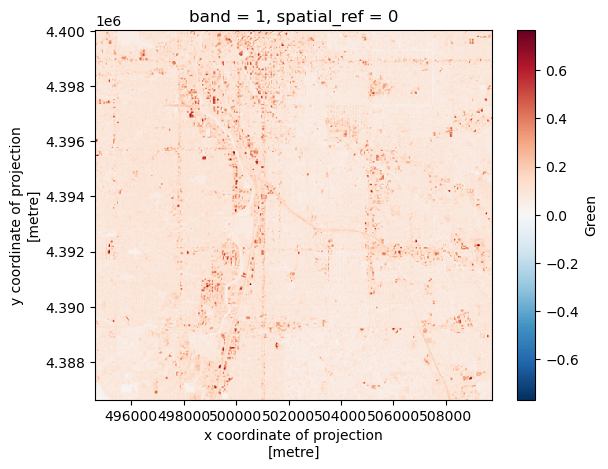

In [7]:
def process_image(uri, bounds_gdf):
    """
    Load, crop, and scale a raster image from earthaccess

    Parameters
    ----------
    uri: file-like or path-like
      File accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to

    Returns
    -------
    cropped_da: rxr.DataArray
      Processed raster
    """
    # Open the raster data
    da = rxr.open_rasterio(uri, mask_and_scale=True).squeeze()

    # Get the study bounds
    bounds = bounds_gdf.to_crs(da.rio.crs).total_bounds

    # crop
    cropped_da  = da.rio.clip_box(*bounds)
    
    return cropped_da

process_image(denver_file_data[8], denver_redlining_gdf).plot()

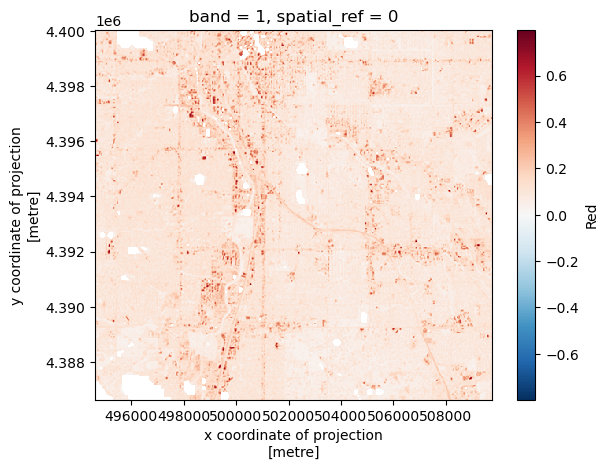

In [8]:
def process_cloud_mask(cloud_uri, bounds_gdf, bits_to_mask):
    """
    Load an 8-bit Fmask file and process to a boolean mask

    Parameters
    ----------
    uri: file-like or path-like
      Fmask file accessor downloaded or obtained from earthaccess
    bounds_gdf: gpd.GeoDataFrame
      Area of interest to crop to
    bits_to_mask: list of int
      The indices of the bits to mask if set

    Returns
    -------
    cloud_mask: np.array
      Cloud mask
    """

    # open fmask file
    fmast_da = process_image(cloud_uri,bounds_gdf,)

    # unpack the cloud mask bits
    cloud_bits = (
        np.unpackbits(
            (
                # Get the cloud mask as an array...
                fmast_da.values
                # ... of 8-bit integers
                .astype('uint8')
                # With an extra axis to unpack the bits into
                [:, :, np.newaxis]
            ), 
            # List the least significat bit first to match the user guide
            bitorder='little',
            # Expand the array in a new dimension
            axis=-1)
    )


    # And add up the bits for each pixel
    cloud_mask = np.sum(
        # Select bits 
        cloud_bits[:,:,bits_to_mask], 
        # Sum along the bit axis
        axis=-1
    )

    # Mask the pixel if the sum is greater than 0
    # (If any of the bits are True)
    cloud_mask = cloud_mask == 0

    return cloud_mask

# # Select only the bits we want to mask
#   bits_to_mask = [
#         1, # Cloud
#         2, # Adjacent to cloud
#         3, # Cloud shadow
#         5] # Water
blue_da = process_image(denver_file_data[1], denver_redlining_gdf) #1 is blue band in this set
denver_cloud_mask = process_cloud_mask(denver_file_data[-1],denver_redlining_gdf,[1,2,3,5])
blue_da.where(denver_cloud_mask).plot()


Our next new tool to help you write DRY and correct code is the regular
expression. Regular expressions are a little like the patterns we use
with `glob` that contain wildcard characters (`*`) – but, they are
**much** more powerful. With regular expressions, we can extract
different segments from a string (file name, in this case) based on
landmarks – even if those segments are not always the same length!

First – run another `earthaccess` search, this time removing the
`count=1` argument, or setting it to `count=-1`. This will include all
the results.

In [9]:
# Search earthaccess 
denver_results = earthaccess.search_data(
    short_name="HLSL30",
    bounding_box=tuple(denver_redlining_gdf.total_bounds),
    # temporal=("2023-07-17"), # works but no granules 
    # temporal=("2023-07-17","2023-07-18"), # gives error
    # temporal=("2023-07-17"),
    temporal=("2023-07-12","2023-07-13"), #class example
    # temporal=("2023-07-01","2023-07-31"),
    # temporal=("2024-10-16","2024-10-17"), #try another day
    
)
    # Check if any results were found
denver_results  

# Open earthaccess 
denver_file_data = earthaccess.open(denver_results)

QUEUEING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/60 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/60 [00:00<?, ?it/s]

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Get metadata with **regular expressions**</div></div><div class="callout-body-container callout-body"><p>Using the code below as a starting point, extract metadata from file
names and put them into a <code>DataFrame</code>. This strategy will
help you later on because you will be able to group rasters by their
metadata values, such as tile ID, band ID, and/or date.</p>
<ol type="1">
<li>Build your regular expression. ChatGPT is a great tool to get
started with your regular expression. You can also check out <a
href="https://regex101.com/">https://regex101.com/</a> to test your
regular expressions, making sure to select the <code>Python</code>
regular expression engine.</li>
<li>Replace file_name with a <strong>string</strong> version of the URI.
You can access it from the object you got from <code>earthaccess</code>
through the <code>.full_name</code> attribute.</li>
<li>Add the URIs from <code>earthaccess</code> to the
<code>DataFrame</code> you created as a new column.</li>
</ol></div></div>

In [10]:
denver_file_data[8].full_name

'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/HLSL30.020/HLS.L30.T13SDD.2023193T173653.v2.0/HLS.L30.T13SDD.2023193T173653.v2.0.B03.tif'

Now you are ready to run your code repeatedly on each raster you want to
load. To do this, we’ll use a structure called a `for` loop, which runs
the same code repeatedly with different variable values. The values that
change are special variables called **looping variables**.

To set up a `for` loop, you can use the following process:

1.  Copy the code you’re using into the `for` loop shell, making sure to
    indent it so Python knows it is part of the loop.
2.  Identify any variables that are **too specific**. For example, if I
    called a `DataArray` `green_da`, but the loop will be processing
    data from other bands…I might change the name to `da` whereever it
    appears.
3.  Identify the **looping variable(s)** and make sure they match your
    code.
4.  Establish an **accumulator** – a data structure to store the result.
    Add what you want to keep from each iteration of the loop to it.
5.  Write some code to test your loop, such as by printing out an
    intermediate value in the loop, or eventually plotting the final
    results. We recommend going line by line when you’re just getting
    started. This usually involves commenting code later on, and
    modifying the accumulator and testing as you go. You can also use
    the `break` keywork to stop the loop after a single iteration for
    testing.

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Process data</div></div><div class="callout-body-container callout-body"><p>Process all your bands. We’ve provided the structure of the
<code>for</code> loop – you will need to call your functions and work
out how to pass them the arguments they need.</p>
<p>Something that is tricky about looping through
<code>DataFrame</code>s is that they tend to wrap values in external
structures like <code>Series</code> (which are the data type of columns
in a <code>DataFrame</code>). The print out of a <code>Series</code>
containing one value and the print out of that value are not identical,
but the are <strong>very similar</strong>. To get a
<strong>value</strong> out from inside a <code>Series</code>, you can
add the following code: <code>.values[0]</code>. This will first remove
the <code>Series</code> wrapper, leaving an array, and the get the first
value in the array.</p></div></div>

In [11]:
# complie a uri to search for metadata

uri_re = re.compile(
    r"HLS\.L30\.(?P<tile_id>T[0-9A-Z]+)\."
    r"(?P<date>\d+)T\d+\.v2\.0\.(?P<band_id>.+)\.tif"
)

# uri_re.search(denver_file_data[8].full_name).groupdict() # was for testint

uri_groups = [
    uri_re.search(denver_file.full_name).groupdict()
    for denver_file in denver_file_data]

# create dataframe with metadata
raster_df = pd.DataFrame(uri_groups)

#add a file like uri to dateframe
raster_df['file_uri'] = denver_file_data

#check the results
raster_df

,tile_id,date,band_id,file_uri
0,T13SDD,2023193,SZA,"<File-like object HTTPFileSystem, https://data..."
1,T13SDD,2023193,B04,"<File-like object HTTPFileSystem, https://data..."
2,T13SDD,2023193,B07,"<File-like object HTTPFileSystem, https://data..."
3,T13SDD,2023193,B01,"<File-like object HTTPFileSystem, https://data..."
4,T13SDD,2023193,VAA,"<File-like object HTTPFileSystem, https://data..."
5,T13SDD,2023193,B02,"<File-like object HTTPFileSystem, https://data..."
6,T13SDD,2023193,SAA,"<File-like object HTTPFileSystem, https://data..."
7,T13SDD,2023193,B06,"<File-like object HTTPFileSystem, https://data..."
8,T13SDD,2023193,B03,"<File-like object HTTPFileSystem, https://data..."
9,T13SDD,2023193,B11,"<File-like object HTTPFileSystem, https://data..."


In [12]:
# Labels for each band to process
bands = {
    'B02': 'red',
    'B03': 'green',
    'B04': 'blue',
    'B05': 'nir'
}
# Initialize structure for saving images
denver_das = {band_name: [] for band_name in bands.values()}

# print(denver_das)    

for tile_id, tile_df in raster_df.groupby('tile_id'):

    # print(tile_id) #testing
    # display(tile_df)#testing

    # # Load the cloud 
    fmask_file = tile_df[tile_df.band_id=='Fmask'].file_uri.values[0] #temp dont rerun search

    # # fmask_da = process_image(fmask_file, denver_redlining_gdf) #testing

    cloud_mask = process_cloud_mask (fmask_file, denver_redlining_gdf,[1,2,3,5])  #temp dont rerun search

    # print(cloud_mask) testing

    for band_id, row in tile_df.groupby('band_id'):   #if multiple dates will need to group by date as well
            # print(band_id) #testing
        
        if band_id in bands:
            band_name = bands[band_id]
            print(band_id, band_name) #testing
            # Process band
            band_da = process_image(row.file_uri.values[0], denver_redlining_gdf)

            # Mask 
            band_masked_da = band_da.where(cloud_mask)
            # display(band_da)  #testing
            # break #testing
        
            # Store the resulting DataArray ofr later
            denver_das[band_name].append(band_masked_da)
    # break testing


B02 red
B03 green
B04 blue
B05 nir
B02 red
B03 green
B04 blue
B05 nir
B02 red
B03 green
B04 blue
B05 nir
B02 red
B03 green
B04 blue
B05 nir


In [13]:
denver_das

{'red': [<xarray.DataArray (y: 447, x: 504)> Size: 901kB
  array([[0.0567, 0.0757, 0.0682, ..., 0.0837, 0.0744, 0.0529],
         [0.0575, 0.0726, 0.0559, ..., 0.0907, 0.0849, 0.0605],
         [0.07  , 0.0672, 0.0625, ..., 0.0949, 0.0826, 0.0674],
         ...,
         [   nan,    nan,    nan, ..., 0.0712, 0.0498, 0.0477],
         [   nan,    nan,    nan, ..., 0.0565, 0.0412, 0.0382],
         [   nan,    nan,    nan, ..., 0.0602, 0.0575, 0.061 ]],
        dtype=float32)
  Coordinates:
      band         int64 8B 1
    * x            (x) float64 4kB 4.947e+05 4.947e+05 ... 5.097e+05 5.097e+05
    * y            (y) float64 4kB 4.4e+06 4.4e+06 4.4e+06 ... 4.387e+06 4.387e+06
      spatial_ref  int64 8B 0
  Attributes: (12/33)
      ACCODE:                    Lasrc; Lasrc
      arop_ave_xshift(meters):   0, 0
      arop_ave_yshift(meters):   0, 0
      arop_ncp:                  0, 0
      arop_rmse(meters):         0, 0
      arop_s2_refimg:            NONE
      ...                 

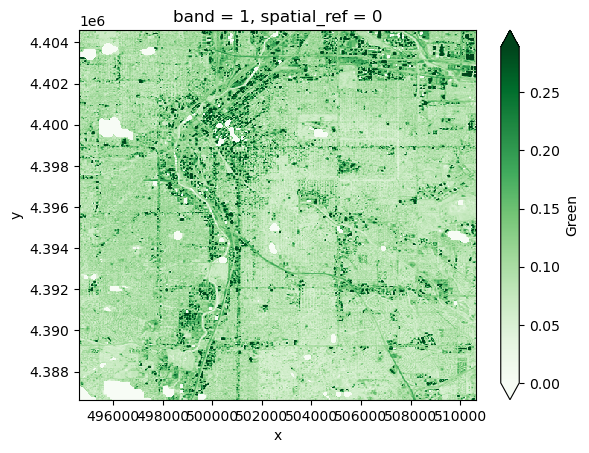

In [14]:

# Merge all tiles
denver_merged_das = {
    band_name: merge_arrays(das) 
    for band_name, das 
    in denver_das.items()}

denver_merged_das['green'].plot(cmap='Greens', robust=True)

<link rel="stylesheet" type="text/css" href="./assets/styles.css"><div class="callout callout-style-default callout-titled callout-task"><div class="callout-header"><div class="callout-icon-container"><i class="callout-icon"></i></div><div class="callout-title-container flex-fill">Try It: Check your data</div></div><div class="callout-body-container callout-body"><p>Make a plot of one of your merged bands with the denver boundary
superimposed. You should now have data for the whole city!</p></div></div>

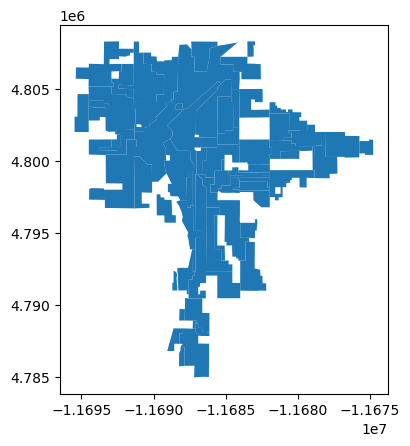

In [15]:
import cartopy.crs as ccrs # CRSs
#area of interest needs to reproject to mercator
denver_reproject_gdf = denver_redlining_gdf.to_crs(ccrs.Mercator())

denver_reproject_gdf.plot()

# need to figure out overlay from back in the redlining plot.

denver_proj_band_dict = {
    name: da.rio.reproject(ccrs.Mercator())
    for name, da in denver_merged_das.items()
}

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

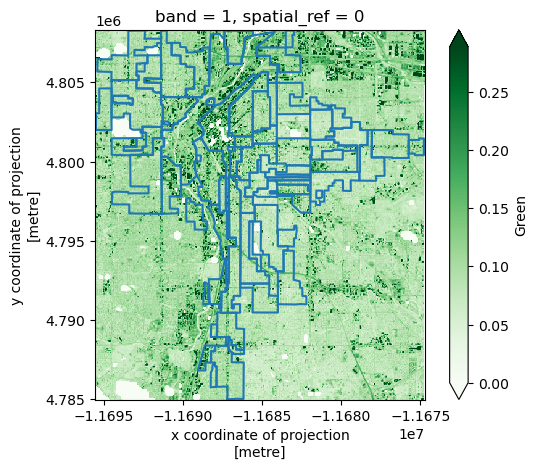

In [16]:
# Plot a merged raster band
import matplotlib.pyplot as plt

# denver_merged_das['green'].plot(cmap='Greens', robust=True)
denver_proj_band_dict['green'].plot(cmap='Greens', robust=True)
denver_reproject_gdf.boundary.plot(ax=plt.gca())


